In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langchain_community tavily-python crewai langchain-cohere

In [1]:
# Helper function to set env variables

import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [2]:
# OpenAI API Key

_set_env("OPENAI_API_KEY")

In [3]:
# Tavily Search API Key

_set_env("TAVILY_API_KEY")

In [4]:
# (Optional) Langgraph tracability

_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "agents-interoperability"

In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

In [6]:
from langchain_openai import OpenAI
openai_llm = OpenAI(model="gpt-4-turbo", temperature=0.7)

In [7]:
import sqlite3
import requests
from langchain_community.utilities.sql_database import SQLDatabase
from sqlalchemy import create_engine
from sqlalchemy.pool import StaticPool
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit

def get_engine_db():
    """Create engine."""
    
    connection = sqlite3.connect("db/portfolio.db", check_same_thread=False)
    
    return create_engine(
        "sqlite://",
        creator=lambda: connection,
        poolclass=StaticPool,
        connect_args={"check_same_thread": False},
    )
engine = get_engine_db()
db = SQLDatabase(engine)
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
db_tools = toolkit.get_tools() # This will be all the SQL tools

In [8]:
from tavily import TavilyClient
from crewai.tools import tool

@tool("TavilySearchTool")
def TavilySearchTool(query: str) -> dict:
    """
    Search the web for relevant information using Tavily Search.
    Args:
        query (str): The search query string.
    Returns:
        dict: A dictionary of search results obtained from Tavily search.
    """
    
    tavily_client = TavilyClient()
    response = tavily_client.search(query=query, max_results=1, include_answer=True)
    return response

web_search_tools = [TavilySearchTool] # This will be the web search tools

In [9]:
from langgraph.prebuilt import create_react_agent

prompt_template = """You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.
DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
To start you should ALWAYS look at the tables in the database to see what you can query.
Do NOT skip this step.
Then you should query the schema of the most relevant tables."""

prompt = prompt_template.format(dialect="SQLite", top_k=5)

sql_agent = create_react_agent(
    llm,
    tools=db_tools,
    prompt=prompt
)

In [10]:
from crewai import Agent, Task, Crew, Process

financial_advisor = Agent(
    role="FINRA-Approved Financial Analyst",
    goal="Analyze a given security and provide insights on its market trends, sector performance, and key competitors.",
    backstory="An AI-powered financial analyst with deep expertise in global markets, providing accurate and timely insights.",
    verbose=True,
    tools=web_search_tools,
    llm=openai_llm
)
financial_analysis_task = Task(
    description=(
        "Search the web for the latest news and performance metrics on {query}. "
        "Summarize its recent trends, sector performance, key competitors, and overall market sentiment."
    ),
    expected_output=(
        "A summary including: \n"
        "- Latest market trends for {query}\n"
        "- Sector performance\n"
        "- Competitor analysis\n"
        "- Buy/sell sentiment based on recent news"
    ),
    tools=web_search_tools,
    agent=financial_advisor
)
crew = Crew(
    agents=[financial_advisor],
    tasks=[financial_analysis_task],
    process=Process.sequential
)

In [11]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages
from langgraph.checkpoint.memory import MemorySaver

class State(MessagesState):
    next: str

In [12]:
def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

In [13]:
def database_query_node(state: State) -> Command[Literal["supervisor"]]:
    result = sql_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="db_query")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

In [14]:
from langchain_core.messages import convert_to_openai_messages

def web_search_node(state: State) -> Command[Literal["supervisor"]]:
    messages = convert_to_openai_messages(state["messages"])
    result = crew.kickoff(inputs={"query": messages[-1]['content']})
    return Command(
        update={
            "messages": [
                HumanMessage(content=result.raw, name="web_search")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

In [15]:
supervisor_node = make_supervisor_node(llm, ["db_query", "web_search"])

In [16]:
builder = StateGraph(State)
builder.add_node("supervisor", supervisor_node)
builder.add_node("db_query", database_query_node)
builder.add_node("web_search", web_search_node)
builder.add_edge(START, "supervisor")
memory = MemorySaver()
react_graph = builder.compile(checkpointer=memory)

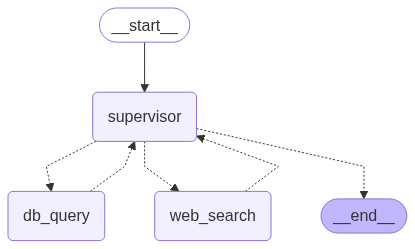

In [17]:
from IPython.display import Image, display
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [18]:
config = {"configurable": {"thread_id": "1", "recursion_limit": 50}}

In [19]:
query = "What are the security holdings of John Doe?"
events = react_graph.stream(
    {"messages": [("user", query)]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What are the security holdings of John Doe?
================================ Human Message =================================

What are the security holdings of John Doe?
================================ Human Message =================================
Name: db_query

John Doe holds the following securities:

1. **S&P 500**
   - Market Value: $8,500,000 USD
   - Industry: Index Fund

2. **MSCI AC World**
   - Market Value: $6,000,000 USD
   - Industry: Index Fund

3. **TOPIX**
   - Market Value: $4,200,000 USD
   - Industry: Index Fund

4. **MSCI AP ex-Japan**
   - Market Value: $5,700,000 USD
   - Industry: Index Fund

5. **STOXX 600**
   - Market Value: $3,500,000 USD
   - Industry: Index Fund
================================ Human Message =================================
Name: db_query

John Doe holds the following securities:

1. **S&P 500**
   - Market Value: $8,500,000 USD
   - Industry: Index Fund



In [20]:
query = "How is S&P 500 performing can you give me a summary?"
events = react_graph.stream(
    {"messages": [("user", query)]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

How is S&P 500 performing can you give me a summary?
================================ Human Message =================================

How is S&P 500 performing can you give me a summary?


╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: FINRA-Approved Financial Analyst                                                                        │
│                                                                                                                 │
│  Task: Search the web for the latest news and performance metrics on How is S&P 500 performing can you give me  │
│  a summary?. Summarize its recent trends, sector performance, key competitors, and overall market sentiment.    │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────── 🔧 Agent Tool Execution ────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: FINRA-Approved Financial Analyst                                                                        │
│                                                                                                                 │
│  Thought: I need to gather the latest information on the S&P 500's performance, including market trends,        │
│  sector performance, competitor analysis, and the overall market sentiment.                                     │
│                                                                                                                 │
│  Using Tool: TavilySearchTool                                                                                   │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Input ───────────────────────────────────────────────────╮
│                                                                                                                 │
│  "{\"query\": \"S&P 500 recent performance 2023\"}"                                                             │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Output ──────────────────────────────────────────────────╮
│                                                                                                                 │
│  {'query': 'S&P 500 recent performance 2023', 'follow_up_questions': None, 'answer': "The S&P 500 had a 24.23%  │
│  increase in 2023. This followed a 19.44% decline in 2022. The index's performance in 2024 is not available.",  │
│  'images': [], 'results': [{'url': 'https://www.macrotrends.net/2526/sp-500-historical-annual-returns',         │
│  'title': 'S&P 500 Historical Annual Returns (1927-2025) - Macrotrends', 'content': 'Chart ; 2023-12-31,        │
│  24.23% ; 2022-12-31, -19.44% ; 2021-12-31, 26.89% ; 2020-12-31, 16.26%.', 'score': 0.72418857, 'raw_content':  │
│  None}], 'response_time': 6.47}                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: FINRA-Approved Financial Analyst                                                                        │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  The S&P 500 experienced a significant rebound in 2023, with an increase of 24.23%. This performance was a      │
│  recovery from a decline of 19.44% in 2022. The robust growth in 2023 reflects a positive shift in market       │
│  sentiment and possibly improvements in economic conditions or sector performances. However, detailed           │
│  information on sector-specific performance, competitor analysis, and the current buy/sell sentiment was not    │
│  obtained in this search. Further detailed analysis would be required to provide insights into these specific   │
│  areas. For more detailed historical performance, you can refer to sources like Macrotrends.                    │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

================================ Human Message =================================
Name: web_search

The S&P 500 experienced a significant rebound in 2023, with an increase of 24.23%. This performance was a recovery from a decline of 19.44% in 2022. The robust growth in 2023 reflects a positive shift in market sentiment and possibly improvements in economic conditions or sector performances. However, detailed information on sector-specific performance, competitor analysis, and the current buy/sell sentiment was not obtained in this search. Further detailed analysis would be required to provide insights into these specific areas. For more detailed historical performance, you can refer to sources like Macrotrends.
================================ Human Message =================================
Name: web_search

The S&P 500 experienced a significant rebound in 2023, with an increase of 24.23%. This performance was a recovery from a decline of 19.44% in 2022. The robust growth in 2023 reflec